In [1]:
import geopandas as gpd
import pandas as pd
import numpy as np
import random
import sys, os.path, os
from tqdm import tqdm
import pickle as pkl
from shapely.geometry import Point,Polygon
import dateutil.parser

import random
from datetime import datetime, timedelta

import sys, os.path, os
try:
    from google.colab import drive
    drive.mount('/content/drive')

    path_opencp="drive/Shareddrives/FAIRNESS/Colab/Librerias/PredictCode/"
    path_fairness="drive/Shareddrives/FAIRNESS/Colab/Librerias/"
    path_exp="drive/Shareddrives/FAIRNESS/Colab/Notebooks_for_topic/EXP0/SCRIPTS/"

except:
    path_opencp="/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Librerias/PredictCode/"
    path_fairness="/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Librerias/"
    path_exp="/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Notebooks_for_topic/EXP0/SCRIPTS/"


sys.path.insert(0, os.path.abspath(path_opencp))
sys.path.insert(0, os.path.abspath(path_fairness))
sys.path.insert(0, os.path.abspath(path_exp))

import open_cp
import open_cp.geometry
import matplotlib.pyplot as plt

try:
  os.chdir("drive/Shareddrives/FAIRNESS/Colab/Notebooks_for_topic/EXP0/DATOS/CHICAGO")
except:
  os.chdir("/Users/diegohernandez/Google Drive/Unidades compartidas/FAIRNESS/Colab/Notebooks_for_topic/EXP0/DATOS/CHICAGO")


Mounted at /content/drive


ERROR:open_cp.geometry:Failed to import `rtree`.


## <center> <font color='red'>1. Cargando data ingresos al geojson de Chicago

In [ ]:
chicago=gpd.read_file('chicago_boundaries.geojson')
chicago['community']=chicago['community'].apply(lambda x: x.upper())
income_chicago=pd.read_csv('socioeconomic_indicators.tsv',sep='\t')
income_chicago['COMMUNITY AREA NAME']=income_chicago['COMMUNITY AREA NAME'].apply(lambda x: x.upper())
income_chicago.rename(columns={'COMMUNITY AREA NAME':'community'},inplace=True)
#localidades=localidades.query("LocCodigo not in ('01','11','19','05','20')")
#localidades.to_file('localidades_filtrada.geojson', driver="GeoJSON")

In [ ]:
income_chicago.head(2)

In [ ]:
chicago.head(2)

In [ ]:
list1=chicago.community.unique()
list2=income_chicago.community.unique()
set(list2)-set(list1),set(list1)-set(list2)

In [ ]:
rename={"MONTCLAIRE":"MONTCLARE","O'HARE":"OHARE","WASHINGTON HEIGHT":"WASHINGTON HEIGHTS"}

In [ ]:
income_chicago=income_chicago.replace({"community": rename})
list2=income_chicago.community.unique()
set(list2)-set(list1)

In [ ]:
chicago_income=chicago.merge(income_chicago[['community','PER CAPITA INCOME ']],on='community',how='left')
chicago_income.rename(columns={'PER CAPITA INCOME ':'income'},inplace=True)
chicago_income=chicago_income[['community','income','geometry']]
chicago_income.to_file('chicago_boundaries_income.geojson',driver='GeoJSON')
chicago_income.head()

In [ ]:
import plotly.express as px

fig = px.violin(chicago_income, y="income", box=True,points='all')
fig.show()

In [ ]:
#definiendo variable protegida como aquellas comuidades cuyo ingreso sea menor a la media de ingresos en los datos.
chicago_income['protected']=chicago_income.income.apply(lambda x: 'Protected' if x<=21323 else 'Unprotected')

In [ ]:
chicago_income.head()

In [ ]:
chicago_income.to_file('chicago_boundaries_income.geojson',driver='GeoJSON')

In [ ]:
chicago_income.query("protected=='Protected'").community.unique(),chicago_income.query("protected=='Unprotected'").community.unique()

## <center> <font color='red'>2. Generando datos Chicago en formato opencp

In [ ]:
data_chicago2021=pd.read_csv('Crimes_-_2021_20231019.tsv',sep='\t')
data_chicago2022=pd.read_csv('Crimes_-_2022_20231019.tsv',sep='\t')
data_chicago2023=pd.read_csv('Crimes_-_2023_20231019.tsv',sep='\t')
localidades=gpd.read_file('chicago_boundaries_income.geojson')

In [ ]:
geometrias=gpd.GeoSeries([i for i in localidades.geometry])
geo=geometrias.unary_union
geo

In [ ]:
data_chicago2021.head(2)

In [ ]:
data_chicago2021[data_chicago2021[['Primary Type','Description','Location']].notnull().all(1)][['Primary Type','Description','Location']].head(6)

In [ ]:
data_chicago2021['Primary Type'].unique()

In [ ]:
data_chicago2022['Primary Type'].unique()

In [ ]:
data_chicago2023['Primary Type'].unique()

In [ ]:
#Filtrando la data para solo los datos de robo
data_chicago2021.query(" (`Primary Type`.str.contains('THEFT')) and (Latitude.notnull()) and (Longitude.notnull()) "
                       , engine='python'
                       , inplace=True)
data_chicago2022.query(" (`Primary Type`.str.contains('THEFT')) and (Latitude.notnull()) and (Longitude.notnull()) "
                       , engine='python'
                       , inplace=True)
data_chicago2023.query(" (`Primary Type`.str.contains('THEFT')) and (Latitude.notnull()) and (Longitude.notnull()) "
                       , engine='python'
                       , inplace=True)

In [ ]:
data_chicago2021['Primary Type'].unique(),data_chicago2022['Primary Type'].unique(),data_chicago2023['Primary Type'].unique()

In [ ]:
data_chicago2021=data_chicago2021[['Date','Longitude','Latitude']]
data_chicago2022=data_chicago2022[['Date','Longitude','Latitude']]
data_chicago2023=data_chicago2023[['Date','Longitude','Latitude']]

data_chicago=pd.concat([data_chicago2021,data_chicago2022,data_chicago2023])

In [ ]:
geometria=[ Point(data_chicago.iloc[i,1],data_chicago.iloc[i,2]) for i in range(len(data_chicago))]
geo_pandas_chic=gpd.GeoDataFrame(data=data_chicago,geometry=geometria)
geo_pandas_chic.crs = 'EPSG:4326'
geo_pandas_chic_planas = geo_pandas_chic.to_crs(epsg=26971)

In [ ]:
geo_pandas_chic_planas['coord_x']=geo_pandas_chic_planas.geometry.apply(lambda x: x.x)
geo_pandas_chic_planas['coord_y']=geo_pandas_chic_planas.geometry.apply(lambda x: x.y)
geo_pandas_chic_planas.head()

In [ ]:
timestamps = geo_pandas_chic_planas.Date.map(dateutil.parser.parse)
xcoords, ycoords = (geo_pandas_chic_planas.coord_x.values, geo_pandas_chic_planas.coord_y.values)

#Uniendo coordenadas y formato de tiempo creado asociado a cada crimen
crime_point_chic_opencp = open_cp.TimedPoints.from_coords(timestamps, xcoords, ycoords)

In [ ]:
localidades.crs = 'EPSG:4326'
localidades_planas = localidades.to_crs(epsg=26971)
geometrias=gpd.GeoSeries([i for i in localidades_planas.geometry])
geo=geometrias.unary_union

In [ ]:
pkl.dump(crime_point_chic_opencp, open('data_chicago_opencp.pkl', "wb"))
pkl.dump(geo, open('geo_chicago.pkl', "wb"))
pkl.dump(localidades_planas, open('chicago_community_filtrada_planas.pkl', "wb"))

localidades_planas.to_file('chicago_community_filtrada_planas.geojson',driver='GeoJSON')
geo_pandas_chic_planas.to_file('data_chichago_community_planas.geojson',driver='GeoJSON')

In [ ]:
geo_pandas_chic_planas.shape

## <center> <font color='red'>3. Generando region rectangular y cuadricula de prediccion.

In [ ]:
localidades=gpd.read_file('chicago_community_filtrada_planas.geojson')
geometrias=gpd.GeoSeries([i for i in localidades.geometry])
geo=geometrias.unary_union

#Generando Grilla para los algoritmos.

minx=geo.bounds[0]
miny=geo.bounds[1]
maxx=geo.bounds[2]
maxy=geo.bounds[3]

x_size=np.round((maxx-minx)/1000,0)
y_size=np.round((maxy-miny)/1000,0)

x_range=abs(maxx-minx)
y_range=abs(maxy-miny)
range_max=max(x_range,y_range)

region = open_cp.RectangularRegion(xmin=minx, xmax=minx+x_size*1000, ymin=miny, ymax=miny+y_size*1000)

#Ventana espacial 1000x1000
grid = open_cp.data.Grid(xsize=1000, ysize=1000, xoffset=minx, yoffset=miny)
grid2 = open_cp.geometry.mask_grid_by_intersection(geo, grid)

In [ ]:
x_size,y_size

In [ ]:
geo

In [ ]:
bounding=gpd.GeoDataFrame({'geometry':[Polygon([(geo.bounds[0], geo.bounds[1])
                        , (geo.bounds[0], geo.bounds[3])
                        , (geo.bounds[2], geo.bounds[3])
                        , (geo.bounds[2], geo.bounds[1])])]})
bounding.crs = "EPSG:4326"
bounding.to_file('chicago_bounding_box.geojson',driver='GeoJSON')
bounding

In [ ]:
pkl.dump(region, open('chicago_definition_region.pkl', "wb"))
pkl.dump(grid2, open('chicago_grilla1_region.pkl', "wb"))
pkl.dump(grid, open('chicago_grilla2_region.pkl', "wb"))

## <center> <font color='red'>4. Generando mascara numpy de areas protegidas y no protegidas

In [ ]:
grid1=pkl.load(open('chicago_grilla1_region.pkl', "rb"))
grid2=pkl.load(open('chicago_grilla2_region.pkl', "rb"))
region=pkl.load(open('chicago_definition_region.pkl', "rb"))
geo=pkl.load(open('geo_chicago.pkl', "rb"))
localidades=gpd.read_file('chicago_community_filtrada_planas.geojson')

In [ ]:
# Coordenadas geográficas
inferior = (geo.bounds[0], geo.bounds[1])
superior = (geo.bounds[0]+x_size*1000, geo.bounds[1]+y_size*1000)

longitud=1000
ancho=1000

mask = np.empty([ int((superior[1] - inferior[1]) / ancho) , int((superior[0] - inferior[0]) / longitud)])
mask.shape

In [ ]:
county=0
cuadricula_chic=gpd.GeoDataFrame()
mask=[]
for y in tqdm(range(int((superior[1] - inferior[1]) / ancho))):
  countx=0
  vector_x=[]
  for x in range(int((superior[0] - inferior[0]) / longitud)):
    # Calcula las coordenadas de los vértices del cuadrado
    xmin = inferior[0] + x * longitud
    xmax = xmin + longitud
    ymin = inferior[1] + y * ancho
    ymax = ymin + ancho

    # Crea el polígono del cuadrado y agrega al GeoDataFrame
    square = Polygon([(xmin, ymin), (xmin, ymax), (xmax, ymax), (xmax, ymin)])

    geo_aux_bog=gpd.GeoDataFrame({'geometry':[square]})
    cuadricula_chic=pd.concat([cuadricula_chic,geo_aux_bog])

    try:
      #mask[countx][county]=localidades[square.intersects(localidades.geometry)].reset_index(drop=True)["LocCodigo"][0]
      vector_x.append(localidades[square.intersects(localidades.geometry)].reset_index(drop=True)["community"][0])
    except:
      vector_x.append(0)
      continue
    countx+=1
  mask.append(np.transpose(vector_x))
  county+=1

In [ ]:
mask=np.array(mask).astype(str)
mask.shape

In [ ]:
cuadricula_chic.crs = "EPSG:26971"
cuadricula_chic.to_file('cuadricula_1km_chicago_planas.geojson',driver='GeoJSON')
pkl.dump(mask, open('chicago_mascara_localidades.pkl', "wb"))

In [ ]:
Protegidos=['OAKLAND', 'FULLER PARK', 'WASHINGTON PARK', 'WOODLAWN',
        'ALBANY PARK', 'BELMONT CRAGIN', 'HERMOSA', 'AVONDALE',
        'HUMBOLDT PARK', 'AUSTIN', 'WEST GARFIELD PARK',
        'EAST GARFIELD PARK', 'NORTH LAWNDALE', 'SOUTH LAWNDALE',
        'LOWER WEST SIDE', 'ARMOUR SQUARE', 'SOUTH SHORE', 'CHATHAM',
        'SOUTH CHICAGO', 'BURNSIDE', 'MCKINLEY PARK', 'ROSELAND',
        'PULLMAN', 'SOUTH DEERING', 'EAST SIDE', 'WEST PULLMAN',
        'RIVERDALE', 'ARCHER HEIGHTS', 'BRIGHTON PARK', 'NEW CITY',
        'WEST ELSDON', 'GAGE PARK', 'WEST LAWN', 'CHICAGO LAWN',
        'WEST ENGLEWOOD', 'ENGLEWOOD', 'GREATER GRAND CROSSING',
        'AUBURN GRESHAM', 'WASHINGTON HEIGHTS']
NoProtegidos=['DOUGLAS', 'GRAND BOULEVARD', 'KENWOOD', 'LINCOLN SQUARE',
        'HYDE PARK', 'ROGERS PARK', 'JEFFERSON PARK', 'FOREST GLEN',
        'NORTH PARK', 'PORTAGE PARK', 'IRVING PARK', 'DUNNING',
        'MONTCLARE', 'WEST RIDGE', 'LOGAN SQUARE', 'WEST TOWN',
        'NEAR WEST SIDE', 'UPTOWN', 'NEAR SOUTH SIDE', 'NORWOOD PARK',
        'NEAR NORTH SIDE', 'LOOP', 'AVALON PARK', 'LAKE VIEW',
        'CALUMET HEIGHTS', 'NORTH CENTER', 'HEGEWISCH', 'GARFIELD RIDGE',
        'BRIDGEPORT', 'CLEARING', 'LINCOLN PARK', 'ASHBURN', 'BEVERLY',
        'MOUNT GREENWOOD', 'MORGAN PARK', 'OHARE', 'EDGEWATER',
        'EDISON PARK']

In [ ]:
mask_protegidos=np.isin(mask,Protegidos)
mask_noprotegidos=np.isin(mask,NoProtegidos)
mask_zeros=np.isin(mask,['0'])

pkl.dump(mask_protegidos, open('chichago_mascara_protegidos.pkl', "wb"))
pkl.dump(mask_noprotegidos, open('chichago_mascara_noprotegidos.pkl', "wb"))
pkl.dump(mask_zeros, open('chichago_mascara_zeros.pkl', "wb"))

In [ ]:
plt.imshow( mask_protegidos , cmap = 'magma')

In [ ]:
plt.imshow( mask_noprotegidos , cmap = 'magma')

In [ ]:
plt.imshow( mask_zeros , cmap = 'magma')

## <center> <font color='red'>5. Split data

In [ ]:
import matplotlib.pyplot as plt
def plot_events(data,f_inicial,f_final):
    #Data ¡no manipulada!
    fig, ax = plt.subplots(ncols=2, figsize=(9,2.5))

    ax[0].scatter(data.xcoords, data.ycoords, marker="+", alpha=0.5)
    ax[0].set_title("Coordinates")
    ax[0].set_xlabel('Coordinate X')
    ax[0].set_ylabel('Coordinate Y')
    # ax[0].set(xlim=[0,1], ylim=[0,1])

    times = data.times_datetime()
    ax[1].scatter(times, data.ycoords, marker="+", alpha=0.1)
    ax[1].set_xlim([f_inicial, f_final])
    # ax[1].set_ylim([0, 1])
    ax[1].set_title("Coordinate Vs Dates")
    ax[1].set_xlabel('Date')
    ax[1].set_ylabel('Coordinate Y')
    fig.autofmt_xdate()
    None

In [ ]:
crime_point_chic_opencp = pkl.load(open("data_chicago_opencp.pkl", "rb")) ## cargar datos
crime_point_chic_opencp=crime_point_chic_opencp[(crime_point_chic_opencp.times_datetime()>=np.datetime64("2021-01-01 00:00:00"))]
len(crime_point_chic_opencp.xcoords)

In [ ]:
mask_times_train=((crime_point_chic_opencp.times_datetime()>=np.datetime64("2022-01-01 00:00:00")) & (crime_point_chic_opencp.times_datetime()<=np.datetime64("2022-12-31 00:00:00")))
mask_times_test=((crime_point_chic_opencp.times_datetime()>=np.datetime64("2023-01-01 00:00:00")) )
Train_chic=crime_point_chic_opencp[mask_times_train]
print(len(Train_chic.xcoords))

pkl.dump(Train_chic, open("Train_chicago.pkl", "wb"))

Test_chic=crime_point_chic_opencp[mask_times_test]
print(len(Test_chic.xcoords))
pkl.dump(Test_chic, open("Test_chicago.pkl", "wb"))

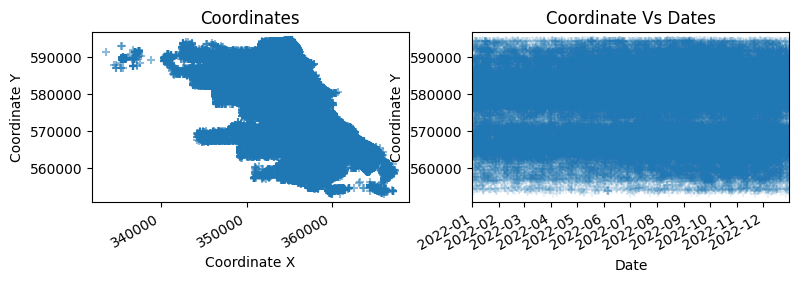

In [ ]:
plot_events(Train_chicago,*Train_chicago.time_range)

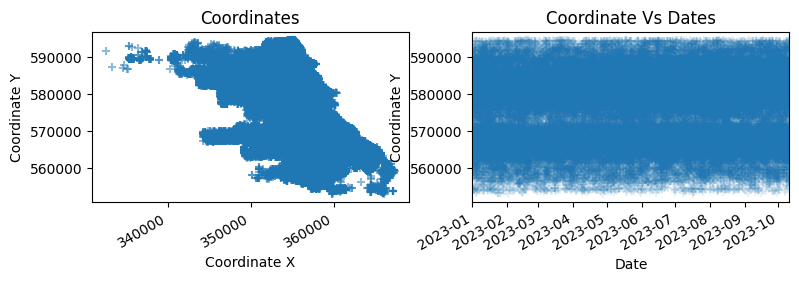

In [ ]:
plot_events(Test_chicago,*Test_chicago.time_range)

## <center> <font color='red'>7. Train and predict Models

In [2]:
Train_chicago = pkl.load(open("Train_chicago.pkl", "rb")) ## cargar datos
Test_chicago = pkl.load(open("Test_chicago.pkl", "rb")) ## cargar datos
region = pkl.load(open("chicago_definition_region.pkl", "rb")) ## cargar datos

In [3]:
len(Train_chicago.xcoords),len(Test_chicago.xcoords),len(Train_chicago.xcoords)+len(Test_chicago.xcoords)

(74279, 65822, 140101)

In [4]:
from models.model_selection import NAIVE_MODEL, KDE_MODEL, SEPP_MODEL
from open_cp.sources.sepp import make_time_unit
from global_vars import days_time_unit
#import datetime
from datetime import timedelta

def intensity_m(model,date,region,grid_size):

    try:
        predict=model.predict(date)
    except:
        predict=model.predict()

    try:
        M=open_cp.predictors.GridPredictionArray.from_continuous_prediction_region(predict, region, grid_size, grid_size)
        intensity_matrix= M.intensity_matrix
    except:
        intensity_matrix = predict.intensity_matrix

    if intensity_matrix.sum()==0:
        return intensity_matrix

    else:
        return intensity_matrix/intensity_matrix.sum()

### datos reales
import open_cp.naive as naive
def get_real_m(timedpoints,p_date,grid_size,region):
    real = timedpoints[(timedpoints.times_datetime()>=p_date) & ((timedpoints.times_datetime()<p_date+timedelta(days=1)))]
    predictor = naive.CountingGridKernel(grid_size,grid_size,region=region)
    predictor.data = real
    try:
        gridpred = predictor.predict().renormalise()
        real=gridpred.intensity_matrix.data

        return real
    except:
        return predictor.predict().intensity_matrix

Failed to load 'descartes' package.
ERROR:open_cp.network:Failed to import `rtree`.


In [5]:
t=np.arange(datetime(2023,1,1,0,0),datetime(2023,10,1,0,0),timedelta(days=1)).astype(datetime)

In [6]:
###### NAIVE
models_by_day={}
for day in range(7):
    path_file=os.path.join("NAIVE/model"+str(day)+".pkl")

    if not os.path.exists(path_file):
        train_filter=Train_chicago[[i[0].astype(datetime).weekday()==day for i in Train_chicago]]
        models_by_day[day]=NAIVE_MODEL(train_filter)
        pkl.dump(models_by_day[day], open(path_file, "wb"))

    else:

        models_by_day[day]=pkl.load(open(path_file, "rb"))

In [ ]:
if not os.path.exists(os.path.join("NAIVE/","predictions2023.pkl")):
    predictions={}
else:
    predictions=pkl.load(open(os.path.join("NAIVE/","predictions2023.pkl"), "rb"))

if not os.path.exists(os.path.join("NAIVE/","reals.pkl")):
    reals={}
else:
    reals=pkl.load(open(os.path.join("NAIVE/","reals.pkl"), "rb"))


#for i in tqdm(range(23+83,282)):
for i in tqdm(t):
    #pred_date=Test_chicago.time_range[0].astype(datetime.datetime)+timedelta(days=i)
    pred_date=i
    if not pred_date in predictions:
        day_filter=pred_date.weekday()

        predict=intensity_m(models_by_day[day_filter],pred_date,region,1000)
        predictions[pred_date]=predict

    # real data
    if not pred_date in reals:
        real=get_real_m(Test_chicago,pred_date,1000,region)
        reals[pred_date]=real
    # try:
    #     EMD[pred_date]=EMD(real,predict,25000000)
    # except:
    #     pass


    pkl.dump(predictions, open(os.path.join("NAIVE/","predictions2023.pkl"), "wb"))
    pkl.dump(reals, open(os.path.join("NAIVE/","reals.pkl"), "wb"))


100%|██████████| 273/273 [5:47:03<00:00, 76.28s/it]  


In [ ]:
###### KDE
import open_cp.kde as kde
models_by_day={}
for day in range(7):
    path_file=os.path.join("KDE/model"+str(day)+".pkl")

    if not os.path.exists(path_file):
        train_filter=Train_chicago[[i[0].astype(datetime).weekday()==day for i in Train_chicago]]
        models_by_day[day]=KDE_MODEL(train_filter,region,1000,kde.ExponentialTimeKernel(7))
        pkl.dump(models_by_day[day], open(path_file, "wb"))

    else:

        models_by_day[day]=pkl.load(open(path_file, "rb"))

In [ ]:
if not os.path.exists(os.path.join("KDE/","predictions2023.pkl")):
    predictions={}
else:
    predictions=pkl.load(open(os.path.join("KDE/","predictions2023.pkl"), "rb"))

if not os.path.exists(os.path.join("KDE/","reals.pkl")):
    reals={}
else:
    reals=pkl.load(open(os.path.join("KDE/","reals.pkl"), "rb"))


#for i in tqdm(range(38+16+14+7+8+34+14+7+10,150)):
for i in tqdm(t):

    #pred_date=Test_chicago.time_range[0].astype(datetime.datetime)+timedelta(days=i)
    pred_date=i
    if not pred_date in predictions:
        day_filter=pred_date.weekday()

        predict=intensity_m(models_by_day[day_filter],pred_date,region,1000)
        predictions[pred_date]=predict

    # real data
    if not pred_date in reals:
        real=get_real_m(Test_chicago,pred_date,1000,region)
        reals[pred_date]=real
    # try:
    #     EMD[pred_date]=EMD(real,predict,25000000)
    # except:
    #     pass


    pkl.dump(predictions, open(os.path.join("KDE/","predictions2023.pkl"), "wb"))
    pkl.dump(reals, open(os.path.join("KDE/","reals.pkl"), "wb"))

In [ ]:
import open_cp.seppexp as sepp

### SEPP
path_file=os.path.join("SEPP/modelgrid.pkl")

if not os.path.exists(path_file):
    trainer = sepp.SEPPTrainer(region, grid_size=1000)
    trainer.data = Train_chicago
    sepp_model_result = trainer.train(iterations=50)
    sepp_model_result.data = Train_chicago
    pkl.dump(sepp_model_result, open(path_file, "wb"))

else:
    sepp_model_result=pkl.load(open(path_file, "rb"))

In [ ]:
if not os.path.exists(os.path.join("SEPP/","predictions_grid.pkl")):
    predictions={}
else:
    predictions=pkl.load(open(os.path.join("SEPP/","predictions_grid.pkl"), "rb"))

if not os.path.exists(os.path.join("SEPP/","reals_grid.pkl")):
    reals={}
else:
    reals=pkl.load(open(os.path.join("SEPP/","reals_grid.pkl"), "rb"))


for i in tqdm(t):

    pred_date=i

    if not pred_date in predictions:
        day_filter=pred_date.weekday()

        predict=intensity_m(sepp_model_result,pred_date,region,1000)
        predictions[pred_date]=predict

    # real data
    if not pred_date in reals:
        real=get_real_m(Test_chicago,pred_date,1000,region)
        reals[pred_date]=real
    # try:
    #     EMD[pred_date]=EMD(real,predict,25000000)
    # except:
    #     pass


    pkl.dump(predictions, open(os.path.join("SEPP/","predictions_grid.pkl"), "wb"))
    pkl.dump(reals, open(os.path.join("SEPP/","reals_grid.pkl"), "wb"))
